In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from math import sqrt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split
from sklearn.svm import SVR
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import clear_output

# Load and PreProcess 

In [26]:
loaded = np.load('data/pems08.npz')
sets = loaded.f.data
print(sets.shape)

(17856, 170, 3)


In [27]:
def get_data(road, features):
    datax = sets[:,0,:features]
    if road <=170:
        for k in range(1,road):
            datax = np.concatenate((datax ,sets[:,k,:features]))
    return datax

In [28]:
dataOG = get_data(1,2)
print(dataOG.shape)

(17856, 2)


In [29]:
# Load the data
dataBefore = dataOG[:,0].reshape(-1,1)

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(dataBefore)

In [30]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

In [31]:
# Create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Reshape the data for the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Models

## ARIMA

In [32]:
xtrainARIMA = train_data
xtestARIMA = test_data
history = xtrainARIMA.tolist()
#arima = auto_arima(xtrainARIMA, start_p=1, start_q=1,test='adf',max_p=5, max_q=5,m=4,d=1,seasonal=True, start_P=0, D=None, trace=True, error_action='ignore',  suppress_warnings=True, stepwise=True,information_criterion='aicc')
order = (5,1,0)
season = (1,0,1,12)


## SVR

## GRU

In [33]:
# Define the model architecture
GRUmodel = Sequential([
    GRU(64, input_shape=(seq_length, 1),return_sequences=True),
    GRU(32, return_sequences=True),
    GRU(64, return_sequences=False),
    Dense(1)
])
# Compile the model
GRUmodel.compile(loss='mean_squared_error', optimizer='adam')


## LSTM

In [34]:
# Define the model architecture
LSTMmodel = Sequential([
    LSTM(64, input_shape=(seq_length, 1),return_sequences=True, unit_forget_bias=True),
    LSTM(32,return_sequences=True),
    LSTM(64,return_sequences=False),
    Dense(1)
])

# Compile the model
LSTMmodel.compile(loss='mean_squared_error', optimizer='adam')

## GCN

# Train & Predict

## ARIMA

In [89]:
ARIMAtestpred = list()
pred_length = 150
for t in range(pred_length):
    model = ARIMA(history, order=order, seasonal_order=season)
    #model = ExponentialSmoothing(history)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    ARIMAtestpred.append(yhat)
    obs = xtestARIMA[t]
    history.append(obs)
    print("Done:",t/pred_length)
    clear_output(wait=True)

Done: 0.9


## SVR

## GRU

In [37]:
# Train the model
GRUmodel.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY))

# Make predictions on the test data
GRUtestPredict = GRUmodel.predict(testX)

Epoch 1/20
223/223 [==============================] - 16s 52ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 2/20
223/223 [==============================] - 11s 47ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/20
223/223 [==============================] - 10s 45ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/20
223/223 [==============================] - 10s 46ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 5/20
223/223 [==============================] - 10s 47ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/20
223/223 [==============================] - 11s 47ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 7/20
223/223 [==============================] - 11s 47ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/20
223/223 [==============================] - 10s 46ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 9/20
223/223 [==============================] - 10s 46ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 10/20
223/223 [==============================] - 10s 47ms/step - loss: 0.001

## LSTM

In [38]:
# Train the model
LSTMmodel.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY))

# Make predictions on the test data
LSTMtestPredict = LSTMmodel.predict(testX)

Epoch 1/20
223/223 [==============================] - 16s 57ms/step - loss: 0.0092 - val_loss: 0.0040
Epoch 2/20
223/223 [==============================] - 12s 52ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/20
223/223 [==============================] - 12s 52ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/20
223/223 [==============================] - 12s 53ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/20
223/223 [==============================] - 12s 52ms/step - loss: 0.001

## GCN

# Result

In [79]:
def plot(title,testPredict,arima=False,svr=False):
    if arima:
        # Calculate root mean squared error
        rmse = sqrt(mean_squared_error(xtestARIMA[:len(testPredict)],testPredict))
        # Calculate R2 score
        r2s = r2_score(y_true=xtestARIMA[:len(testPredict)],y_pred=testPredict)
        
        print(title)
        print('Test RMSE: %.2f' % rmse)
        print('Test R2: %.2f' % r2s)
        
        plt.plot(xtestARIMA,color = 'blue',label = "Actual")
        plt.plot(testPredict, color='red', label = "Prediction")
        plt.xlabel('Date')
        plt.ylabel("Flow (Vehicale / hour)")
        plt.title('Traffic flow with ARIMA')
        plt.xlim(0,len(testPredict)-1)
        plt.legend()
        plt.show()
        return
    elif svr:
        return
    else:
        # Inverse transform the predictions values
        invtestPred = scaler.inverse_transform(testPredict)

        # Calculate root mean squared error
        rmse = sqrt(mean_squared_error(invtestY[0],invtestPred.reshape(-1,1)))
        # Calculate R2 score
        r2s = r2_score(y_true=testYshape,y_pred=invtestPred)
    
        print(title)
        print('Test RMSE: %.2f' % rmse)
        print('Test R2: %.2f' % r2s)

        plt.figure(figsize=(10,5))
        plt.plot(testY,color = 'red',label = 'Actual')
        plt.plot(testPredict,color = 'blue',label = 'Prediction')
        plt.legend()
        plt.title(title)
        plt.xlim(300,400)
        plt.show()

In [40]:
# Inverse transform the actual values
invtestY = scaler.inverse_transform([testY])
testYshape=invtestY.reshape(len(invtestY[0]),1)

## ARIMA

In [ ]:
plot("ARIMA",ARIMAtestpred,arima=True)

## SVR

In [ ]:
plot("SVR",,svr=True)

## GRU

GRU
Test RMSE: 28.93
Test R2: 0.96


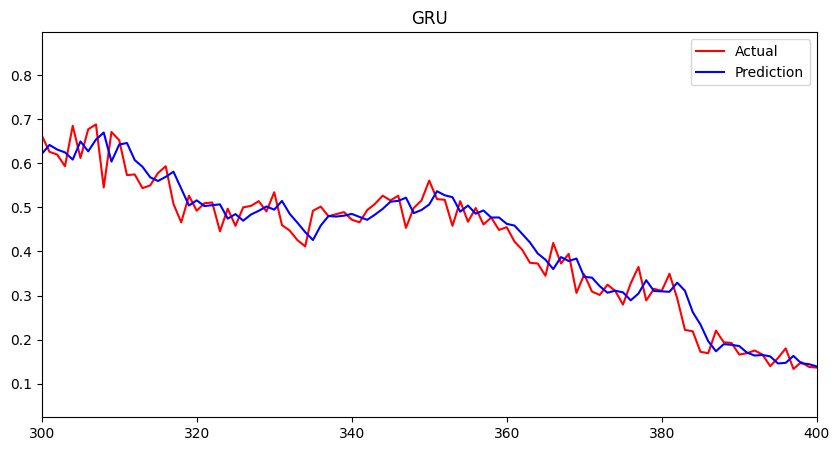

In [81]:
plot("GRU",GRUtestPredict)

## LSTM

LSTM
Test RMSE: 28.44
Test R2: 0.96


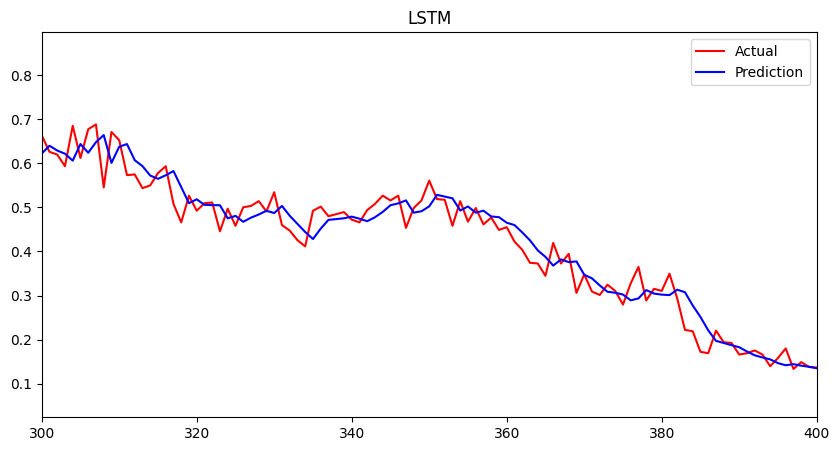

In [82]:
plot("LSTM",LSTMtestPredict)

## GCN